Mini Project - Take 4
By Marissa Beaty

This code was taken and adapted from a website run by Aryan Esfandiari, available here: https://www.aryan.no/post/pix2pix/pix2pix/.  It utilizes Pytorch Lightning to run the model more efficiently. 

In [1]:
import glob
from PIL import Image
from collections import OrderedDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import dill as pickle
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF

import pytorch_lightning as pl # pip install pytorch-lightning
from torchmetrics.functional import (peak_signal_noise_ratio, structural_similarity_index_measure, accuracy) # pip install torchmetrics
from torchsummary import summary # pip install torchsummary
import segmentation_models_pytorch as smp # pip install segmentation-models-pytorch

print(f'Pytorch: {torch.__version__}')
print(f'Pytorch Vision: {torchvision.__version__}')
print(f'Pytorch Lightning: {pl.__version__}')

Pytorch: 1.13.1
Pytorch Vision: 0.14.1
Pytorch Lightning: 1.9.4


In [2]:
DATASET_TRAIN_PATH = 'Image_pairs/Training'
DATASET_TEST_PATH = 'Image_pairs/Test/'
TRAIN_BATCH_SIZE = 32
TRAIN_IMAGE_SIZE = 512
VAL_BATCH_SIZE = 16
VAL_IMAGE_SIZE = 512
TEST_BATCH_SIZE = 20
TEST_IMAGE_SIZE = 512
LAMBDA = 100
NUM_EPOCH = 100
AVAILABLE_GPUS = torch.cuda.device_count()

In [3]:
class HorizontalSplit(torch.nn.Module):
    """
    Split the image in two, horizontally
    E.g. (1, 3, 256, 512) -> (2, 3, 256, 256) if the ratio is 0.5
    """
    def __init__(self, ratio=0.5):
        super(HorizontalSplit, self).__init__()
        self.ratio = ratio
    
    def forward(self, image):
        w, h = image.size
        idx = int(w * self.ratio)
        left = TF.crop(image, top=0, left=0, height=h, width=idx)
        right = TF.crop(image, top=0, left=idx, height=h, width=idx)
        return left, right      

In [4]:
class SketchDataset(Dataset):
    """
    Dataset class for Edges-to-RGB datasets such as edges2handbags and edges2shoes
    Download: http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/
    """
    def __init__(self, filenames, split='train', transform=None):
        self.filenames = filenames
        self.split = split
        
        # Data transform
        if not transform:
            if self.split == 'train':
                self.transform = transforms.Compose([
                    HorizontalSplit(0.5),
                    transforms.Lambda(lambda images: torch.stack([transforms.ToTensor()(item) for item in images])),
                    transforms.CenterCrop((TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(45, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, fill=1),
                ])
            elif self.split == 'val':
                self.transform = transforms.Compose([
                    HorizontalSplit(0.5),
                    transforms.Lambda(lambda images: torch.stack([transforms.ToTensor()(item) for item in images])),
                    transforms.CenterCrop((VAL_IMAGE_SIZE, VAL_IMAGE_SIZE)),
                ])
            else:
                self.transform = transforms.Compose([
                    HorizontalSplit(0.5),
                    transforms.Lambda(lambda images: torch.stack([transforms.ToTensor()(item) for item in images])),
                ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image = Image.open(self.filenames[idx])
        image = self.transform(image)
        image, target = torch.split(image, 1)
        image = torch.squeeze(image)
        # Convert image (edges) to real grayscale e.g. 1-D
        image = TF.rgb_to_grayscale(image)
        target = torch.squeeze(target)
        return image, target

In [5]:
filenames = sorted(glob.glob('Image_pairs/Training/*.png'))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.1)
print(f'Train dataset: {len(train_filenames)} - Validation dataset: {len(val_filenames)}')

Train dataset: 812 - Validation dataset: 91


AttributeError: Can't pickle local object 'SketchDataset.__init__.<locals>.<lambda>'

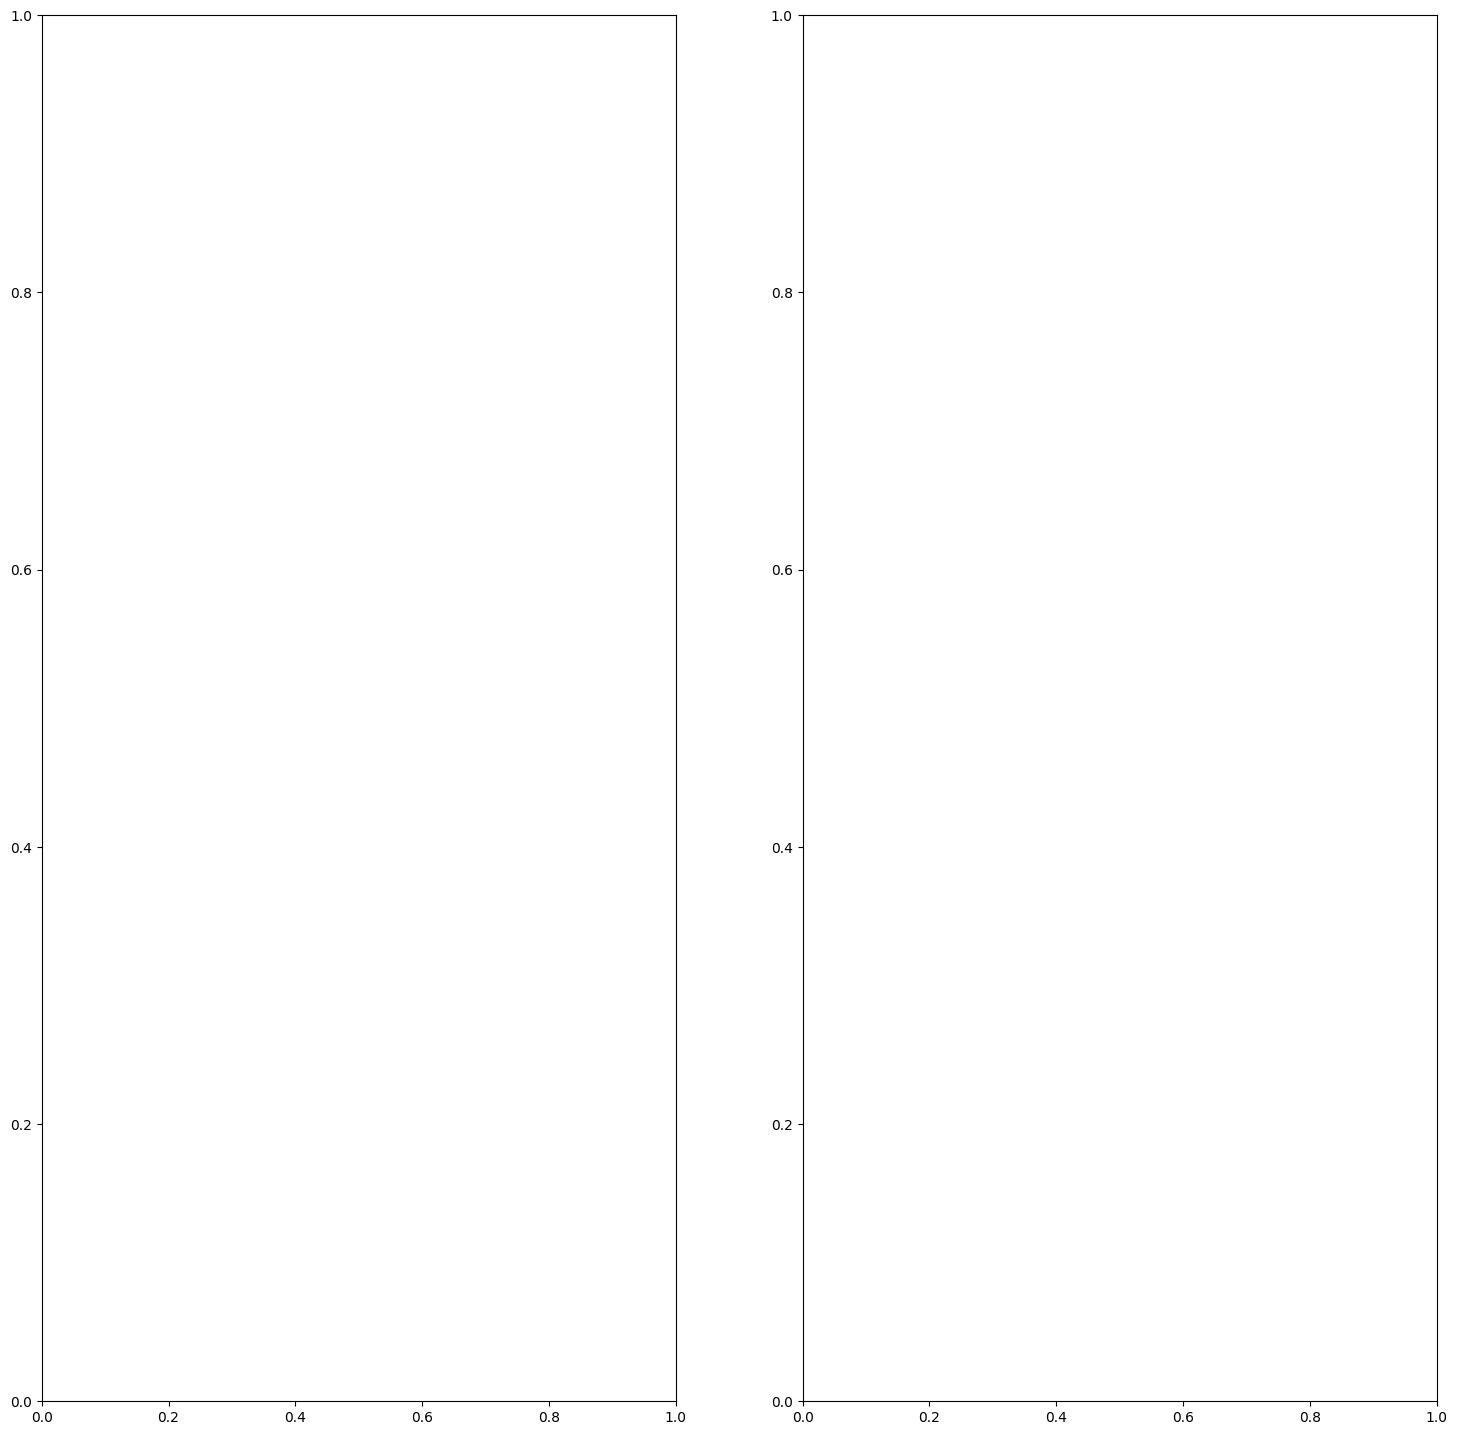

In [7]:
# Training dataset and datalaoder
train_dataset = SketchDataset(train_filenames, split='train')
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=16, shuffle=True, drop_last=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))

data = next(iter(train_dataloader))
image, target = data

grid_image = torchvision.utils.make_grid(image, nrow=16)
ax1.imshow(grid_image.permute(1, 2, 0))
grid_image = torchvision.utils.make_grid(target, nrow=16)
ax2.imshow(grid_image.permute(1, 2, 0))

In [ ]:
# Validation dataset and dataloader
val_dataset = SketchDataset(val_filenames, split='val')
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, num_workers=8, shuffle=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))

data = next(iter(val_dataloader))
image, target = data
grid_image = torchvision.utils.make_grid(image, nrow=16)
ax1.imshow(grid_image.permute(1, 2, 0))
grid_image = torchvision.utils.make_grid(target, nrow=16)
ax2.imshow(grid_image.permute(1, 2, 0))

In [ ]:
test_filenames = sorted(glob.glob(f'{DATASET_TEST_PATH}/*.jpg'))
test_dataset = SketchDataset(test_filenames, split='test')
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

data = next(iter(test_dataloader))
image, target = data
grid_image = torchvision.utils.make_grid(image, nrow=10)
plt.imshow(grid_image.permute(1, 2, 0))

In [ ]:
class Generator(nn.Module):
    def __init__(self, dropout_p=0.4):
        super(Generator, self).__init__()
        self.dropout_p = dropout_p
        # Load Unet with Resnet34 Embedding from SMP library. Pre-trained on Imagenet
        self.unet = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", 
                             in_channels=1, classes=3, activation=None)
        # Adding two layers of Dropout as the original Unet doesn't have any
        # This will be used to feed noise into the networking during both training and evaluation
        # These extra layers will be added on decoder part where 2D transposed convolution is occured
        for idx in range(1, 3):
            self.unet.decoder.blocks[idx].conv1.add_module('3', nn.Dropout2d(p=self.dropout_p))
        # Disabling in-place ReLU as to avoid in-place operations as it will
        # cause issues for double backpropagation on the same graph
        for module in self.unet.modules():
            if isinstance(module, nn.ReLU):
                module.inplace = False

    def forward(self, x):
        x = self.unet(x)
        x = F.relu(x)
        return x

In [ ]:
generator = Generator()
summary(generator, input_size=(1, 256, 256), device='cpu')

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, dropout_p=0.4):
        super(Discriminator, self).__init__()
        self.dropout_p = dropout_p
        self.model = nn.Sequential(OrderedDict([
          ('conv1', nn.Conv2d(4, 128, 3, stride=2, padding=2)),
          ('bn1', nn.BatchNorm2d(128)),
          ('relu1', nn.ReLU()),
          ('conv2', nn.Conv2d(128, 256, 3, stride=2, padding=2)),
          ('bn2', nn.BatchNorm2d(256)),
          ('relu2', nn.ReLU()),
          ('conv3', nn.Conv2d(256, 512, 3)),
          ('dropout3', nn.Dropout2d(p=self.dropout_p)),
          ('bn3', nn.BatchNorm2d(512)),
          ('relu3', nn.ReLU()),
          ('conv4', nn.Conv2d(512, 1024, 3)),
          ('dropout4', nn.Dropout2d(p=self.dropout_p)),
          ('bn4', nn.BatchNorm2d(1024)),
          ('relu4', nn.ReLU()),
          ('conv5', nn.Conv2d(1024, 512, 3, stride=2, padding=2)),
          ('dropout5', nn.Dropout2d(p=self.dropout_p)),
          ('bn5', nn.BatchNorm2d(512)),
          ('relu5', nn.ReLU()),
          ('conv6', nn.Conv2d(512, 256, 3, stride=2, padding=2)),
          ('dropout6', nn.Dropout2d(p=self.dropout_p)),
          ('bn6', nn.BatchNorm2d(256)),
          ('relu6', nn.ReLU()),
          ('conv7', nn.Conv2d(256, 128, 3)),
          ('bn7', nn.BatchNorm2d(128)),
          ('relu7', nn.ReLU()),
          ('conv8', nn.Conv2d(128, 1, 3)),
        ]))

    def forward(self, x):
        # Input: {Grayscale image, RGB target} concatenated along the channel-axis
        x = self.model(x)
        x = F.sigmoid(x)
        return  x

In [ ]:
discriminator = Discriminator()
summary(discriminator, input_size=(4, 256, 256), device='cpu')

In [ ]:
class Pix2Pix(pl.LightningModule):
    def __init__(self, generator_dropout_p=0.4, discriminator_dropout_p=0.4, generator_lr=1e-3, discriminator_lr=1e-6, 
                 weight_decay=1e-5, lr_scheduler_T_0=1e3, lr_scheduler_T_mult=2):
        super(Pix2Pix, self).__init__()
        self.save_hyperparameters()
        # Important to disable automatic optimization as it 
        # will be done manually as there are two optimizators
        self.automatic_optimization = False
        self.generator_lr = generator_lr               # Generator learning rate
        self.discriminator_lr = discriminator_lr       # Discriminator learning rate
        self.weight_decay = weight_decay               # Weight decay e.g. L2 regularization
        self.lr_scheduler_T_0 = lr_scheduler_T_0       # Optimizer initial restart step number
        self.lr_scheduler_T_mult = lr_scheduler_T_mult # Optimizer restart step number factor
        
        # Models
        self.generator = Generator(dropout_p=generator_dropout_p)
        self.discriminator = Discriminator(dropout_p=discriminator_dropout_p)

    def forward(self, x):
        return self.generator(x)
    
    def generator_loss(self, prediction_image, target_image, prediction_label, target_label):
        """
        Generator loss (a combination of): 
            1 - Binary Cross-Entropy
                Between predicted labels (generated by the discriminator) and target labels which is all 1s
            2 - L1 / Mean Absolute Error (weighted by lambda)
                Between generated image and target image
            3 - L2 / Mean Squared Error (weighted by lambda)
                Between generated image and target image
        """
        bce_loss = F.binary_cross_entropy(prediction_label, target_label)
        l1_loss = F.l1_loss(prediction_image, target_image)
        mse_loss = F.mse_loss(prediction_image, target_image)
        return bce_loss, l1_loss, mse_loss
    
    def discriminator_loss(self, prediction_label, target_label):
        """
        Discriminator loss: 
            1 - Binary Cross-Entropy
                Between predicted labels (generated by the discriminator) and target labels
                The target would be all 0s if the input of the discriminator is the generated image (generator)
                The target would be all 1s if the input of the discriminator is the target image (dataloader)
        """
        bce_loss = F.binary_cross_entropy(prediction_label, target_label)
        return bce_loss
    
    def configure_optimizers(self):
        """
        Using Adam optimizer for both generator and discriminator including L2 regularization
        Both would have different initial learning rates
        Stochastic Gradient Descent with Warm Restarts is also added as learning scheduler (https://arxiv.org/abs/1608.03983)
        """
        # Optimizers
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.generator_lr, weight_decay=self.weight_decay)
        discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.discriminator_lr, weight_decay=self.weight_decay)
        # Learning Scheduler
        genertator_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(generator_optimizer, T_0=self.lr_scheduler_T_0, T_mult=self.lr_scheduler_T_mult)
        discriminator_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(discriminator_optimizer, T_0=self.lr_scheduler_T_0, T_mult=self.lr_scheduler_T_mult)
        return [generator_optimizer, discriminator_optimizer], [genertator_lr_scheduler, discriminator_lr_scheduler]

    def training_step(self, batch, batch_idx):
        # Optimizers
        generator_optimizer, discriminator_optimizer = self.optimizers()
        generator_lr_scheduler, discriminator_lr_scheduler = self.lr_schedulers()
        
        image, target = batch
        image_i, image_j = torch.split(image, TRAIN_BATCH_SIZE // 2)
        target_i, target_j = torch.split(target, TRAIN_BATCH_SIZE // 2)
        
        ######################################
        #  Discriminator Loss and Optimizer  #
        ######################################
        # Generator Feed-Forward
        generator_prediction = self.forward(image_i)
        generator_prediction = torch.clip(generator_prediction, 0, 1)
        # Discriminator Feed-Forward
        discriminator_prediction_real = self.discriminator(torch.cat((image_i, target_i), dim=1))
        discriminator_prediction_fake = self.discriminator(torch.cat((image_i, generator_prediction), dim=1))
        # Discriminator Loss
        discriminator_label_real = self.discriminator_loss(discriminator_prediction_real, 
                                                           torch.ones_like(discriminator_prediction_real))
        discriminator_label_fake = self.discriminator_loss(discriminator_prediction_fake,
                                                           torch.zeros_like(discriminator_prediction_fake))
        discriminator_loss = discriminator_label_real + discriminator_label_fake
        # Discriminator Optimizer
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        discriminator_lr_scheduler.step()
        
        ##################################
        #  Generator Loss and Optimizer  #
        ##################################
        #  Generator Feed-Forward
        generator_prediction = self.forward(image_j)
        generator_prediction = torch.clip(generator_prediction, 0, 1)
        # Discriminator Feed-Forward
        discriminator_prediction_fake = self.discriminator(torch.cat((image_j, generator_prediction), dim=1))
        # Generator loss
        generator_bce_loss, generator_l1_loss, generator_mse_loss = self.generator_loss(generator_prediction, target_j,
                                                                                        discriminator_prediction_fake,
                                                                                        torch.ones_like(discriminator_prediction_fake))
        generator_loss = generator_bce_loss + (generator_l1_loss * LAMBDA) + (generator_mse_loss * LAMBDA)
        # Generator Optimizer
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        generator_lr_scheduler.step()
        
        # Progressbar and Logging
        loss = OrderedDict({'train_g_bce_loss': generator_bce_loss, 'train_g_l1_loss': generator_l1_loss, 'train_g_mse_loss': generator_mse_loss,
                            'train_g_loss': generator_loss, 'train_d_loss': discriminator_loss,
                            'train_g_lr': generator_lr_scheduler.get_last_lr()[0], 'train_d_lr': discriminator_lr_scheduler.get_last_lr()[0]})
        self.log_dict(loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        image, target = batch
        
        # Generator Feed-Forward
        generator_prediction = self.forward(image)
        generator_prediction = torch.clip(generator_prediction, 0, 1)
        # Generator Metrics
        generator_psnr = psnr(generator_prediction, target)
        generator_ssim = ssim(generator_prediction, target)
        discriminator_prediction_fake = self.discriminator(torch.cat((image, generator_prediction), dim=1))
        generator_accuracy = accuracy(discriminator_prediction_fake, torch.ones_like(discriminator_prediction_fake, dtype=torch.int32))
        
        # Discriminator Feed-Forward
        discriminator_prediction_real = self.discriminator(torch.cat((image, target), dim=1))
        discriminator_prediction_fake = self.discriminator(torch.cat((image, generator_prediction), dim=1))
        # Discriminator Metrics
        discriminator_accuracy = accuracy(discriminator_prediction_real, torch.ones_like(discriminator_prediction_real, dtype=torch.int32)) * 0.5 + \
                                accuracy(discriminator_prediction_fake, torch.zeros_like(discriminator_prediction_fake, dtype=torch.int32)) * 0.5
            
        # Progressbar and Logging
        metrics = OrderedDict({'val_g_psnr': generator_psnr, 'val_g_ssim': generator_ssim,
                               'val_g_accuracy': generator_accuracy, 'val_d_accuracy': discriminator_accuracy})
        
        self.log_dict(metrics, prog_bar=True)
        return metrics

In [ ]:
class EpochInference(pl.callbacks.base.Callback):
    """
    Callback on each end of training epoch
    The callback will do inference on test dataloader based on corresponding checkpoints
    The results will be saved as an image with 4-rows:
        1 - Input image e.g. grayscale edged input
        2 - Ground-truth
        3 - Single inference
        4 - Mean of hundred accumulated inference
    Note that the inference have a noise factor that will generate different output on each execution
    """
    def __init__(self, dataloader, *args, **kwargs):
        super(EpochInference, self).__init__(*args, **kwargs)
        self.dataloader = dataloader
        
    def on_train_epoch_end(self, trainer, pl_module):
        super(EpochInference, self).on_train_epoch_end(trainer, pl_module)
        data = next(iter(self.dataloader))
        image, target = data
        image = image.cuda()
        target = target.cuda()
        with torch.no_grad():
            # Take average of multiple inference as there is a random noise
            # Single
            reconstruction_init = pl_module.forward(image)
            reconstruction_init = torch.clip(reconstruction_init, 0, 1)
            # Mean
            reconstruction_mean = torch.stack([pl_module.forward(image) for _ in range(100)])
            reconstruction_mean = torch.clip(reconstruction_mean, 0, 1)
            reconstruction_mean = torch.mean(reconstruction_mean, dim=0)
        # Grayscale 1-D to 3-D
        image = torch.stack([image for _ in range(3)], dim=1)
        image = torch.squeeze(image)
        grid_image = torchvision.utils.make_grid(torch.cat([image, target, reconstruction_init, reconstruction_mean], dim=0), nrow=20)
        torchvision.utils.save_image(grid_image, fp=f'{trainer.log_dir}/epoch-{trainer.current_epoch:04}.png')

In [ ]:
epoch_inference_callback = EpochInference(test_dataloader)
checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint()

model = Pix2Pix(generator_dropout_p=0.4, discriminator_dropout_p=0.25,
                generator_lr=1e-3, discriminator_lr=1e-5, 
                lr_scheduler_T_0=len(train_dataloader) * 2)

trainer = pl.Trainer(gpus=1, max_epochs=NUM_EPOCH, val_check_interval=0.5, default_root_dir='./pix2pix/', 
                     callbacks=[epoch_inference_callback, checkpoint_callback])
trainer.fit(model, train_dataloader, val_dataloader)

In [ ]:
checkpoint = sorted(glob.glob('./pix2pix/checkpoints/*.ckpt'), key=os.path.getmtime)[0]
checkpoint = torch.load(checkpoint)
model = Pix2Pix()
model.load_state_dict(checkpoint['state_dict'], strict=True)

In [ ]:
data = next(iter(test_dataloader))
image, _ = data
with torch.no_grad():
    reconstruction = model(image)
    reconstruction = torch.clip(reconstruction, 0, 1)

image = torch.stack([image for _ in range(3)], dim=1)
image = torch.squeeze(image)
grid_image = torchvision.utils.make_grid(torch.cat([image, reconstruction]), nrow=20)
plt.figure(figsize=(24, 24))
plt.imshow(grid_image.permute(1, 2, 0))

This code reached an error in cell 7 saying "Can't pickle local object 'SketchDataset.__init__.<locals>.<lambda>'." Doing research on this specific error, I found that the pickle function does better when using a global object rather than a local object. I attempted to adjust the code using example 2 from this website: https://www.pythonpool.com/cant-pickle-local-object/. Unfortunately, this did not solve the error. I then found that sometimes where Pickle doesn't work, Dill can be used in replace. I did attempt to import dill and implement it where Pickle was used, but came to the same error and went back to the original code. I attempted to do more research on a solution for this error, but without sufficient success. 